In [3]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import  xgboost
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import grangercausalitytests, adfuller
import statsmodels
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import tensorflow
from tensorflow import keras
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
import warnings
warnings.filterwarnings('ignore')

In [7]:
SecurityName="NEPSE"
timeFrame='1D'

#model_data\NEPSE\1D\NEPSE_1D.csv, relative path is this,

current_directory = os.getcwd()

# Move one folder up from the current directory
parent_directory = os.path.dirname(current_directory)

# Move inside the model_data directory
folder_name = os.path.join(parent_directory, "model_data", SecurityName, timeFrame)
csv_path = os.path.join(folder_name, f"{SecurityName}_{timeFrame}.csv")

# folder_name = os.path.join(os.path.dirname(os.path.dirname(__file__)), "model_data", f"{SecurityName}", f"{timeFrame}")
# csv_path = os.path.join(folder_name, f"{SecurityName}_{timeFrame}.csv")

#df = pd.read_csv(csv_path)

df = pd.read_csv(
    csv_path,
    sep=',',
    index_col='date',
    parse_dates=['date'],
    date_parser=lambda dates: pd.to_datetime(dates, format='%Y-%m-%d')  ).fillna(0)

df.columns = stock_data.columns.str.capitalize()

df

,Open,High,Low,Close,Volume
date,,,,,
2003-07-17,204.41,204.4100,204.4100,204.41,0.000000e+00
2003-07-18,204.31,204.3100,204.3100,204.31,0.000000e+00
2003-07-21,203.69,203.6900,203.6900,203.69,0.000000e+00
2003-07-22,203.56,203.5600,203.5600,203.56,0.000000e+00
2003-07-23,203.54,203.5400,203.5400,203.54,0.000000e+00
...,...,...,...,...,...
2024-06-02,2073.06,2086.4444,2068.0816,2083.04,4.310095e+09
2024-06-03,2087.80,2096.5725,2073.0267,2079.07,4.003299e+09
2024-06-04,2087.03,2092.7111,2077.5665,2085.30,4.083831e+09


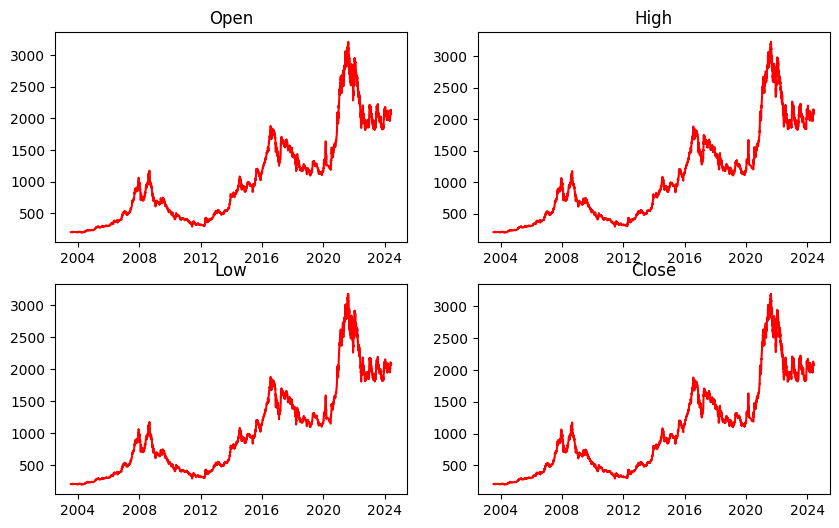

In [8]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 6))

# Loop through axes and plot data with titles
for i, ax in enumerate(axes.flatten()):
    data = df[df.columns[i]]
    ax.plot(data, color='red')

    # Set chart title using ax.set_title()
    ax.set_title(df.columns[i])  # Use the corresponding column name as title


In [9]:
null_mask = df.isnull().any(axis=1)
df[null_mask]
# no null values in the data
# df['Close']= df['Close'].fillna(method ='bfill')


,Open,High,Low,Close,Volume
date,,,,,


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4811 entries, 2003-07-17 to 2024-06-06
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    4811 non-null   float64
 1   High    4811 non-null   float64
 2   Low     4811 non-null   float64
 3   Close   4811 non-null   float64
 4   Volume  4811 non-null   float64
dtypes: float64(5)
memory usage: 225.5 KB


BASELINE MODEL
Let us make a persistence model to be used as a baseline model to use as a reference for our further models. This model will simply use the last period's value to predict the next value. Also, this would be a univariate model

In [12]:
df_baseline = pd.DataFrame(df['Close'])
df_baseline['Close_lag'] = df_baseline['Close'].shift(+1)
df_baseline


,Close,Close_lag
date,,
2003-07-17,204.41,NaN
2003-07-18,204.31,204.41
2003-07-21,203.69,204.31
2003-07-22,203.56,203.69
2003-07-23,203.54,203.56
...,...,...
2024-06-02,2083.04,2069.53
2024-06-03,2079.07,2083.04
2024-06-04,2085.30,2079.07


In [13]:
def model_persistence(x):
    return x

In [14]:
baseline_scaler = StandardScaler()
scaled_baseline = baseline_scaler.fit_transform(df_baseline)

In [15]:
df_baseline_scaled = pd.DataFrame(scaled_baseline, columns = df_baseline.columns, index = df_baseline.index )


In [16]:
df_baseline_scaled.dropna()


,Close,Close_lag
date,,
2003-07-18,-1.165847,-1.165541
2003-07-21,-1.166715,-1.165681
2003-07-22,-1.166897,-1.166549
2003-07-23,-1.166925,-1.166731
2003-07-24,-1.167276,-1.166759
...,...,...
2024-06-02,1.464946,1.446500
2024-06-03,1.459387,1.465421
2024-06-04,1.468111,1.459861


In [17]:
train_size = int((len(df_baseline_scaled)*0.8))
train, test = df_baseline_scaled[1:train_size], df_baseline_scaled[train_size:]

In [18]:
trainX = train['Close_lag']
trainY = train['Close']

In [19]:
testX= test['Close_lag']
testY = test['Close']

In [20]:
# walk-forward validation
predictions = list()
for x in testX:
    yhat = model_persistence(x)
    predictions.append(yhat)
test_score = mean_squared_error(testY, predictions, squared = False)
print('Test MSE: %.3f' % test_score)

Test MSE: 0.047


In [22]:
pred = pd.DataFrame(predictions)
pred = pred.set_index(testY.index, 'Date')
pred = pred.rename(columns = {0: 'Predictions'})

TypeError: DataFrame.set_index() takes 2 positional arguments but 3 were given